# Notebook for single trial PCA
## single reach trials only (all stim conditions), 50ms before lift to 300ms after behavior ends (assuming 260ms for at mouth)

In [102]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, get_trial_PCA
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps

In [103]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [104]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [105]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach trials

In [106]:
control_idxs = np.where(data["pattern_id"] == 0)[0]
control_idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  21,  27,  33,  39,  45,  51,  57,  63,  69,  75,
        81,  87,  93,  99, 105, 111, 117, 123, 129, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449])

In [107]:
stim_idxs = np.where(data["pattern_id"][:150] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
control_idxs = np.sort(np.concatenate((control_idxs, stim_idxs)))

In [108]:
# get no laser trials
control_idxs = np.intersect1d(control_idxs, np.where(data["single"] == 1)[1])

In [109]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        17,  19,  20,  21,  23,  24,  30,  33,  36,  39,  40,  43,  44,
        45,  46,  49,  50,  51,  53,  54,  60,  61,  62,  63,  67,  69,
        70,  71,  74,  77,  81,  82,  88,  89,  91, 105, 107, 116, 117,
       137, 139, 145, 148])

In [110]:
np.unique(data["pattern_id"][control_idxs])

array([ 0, 14, 17, 20], dtype=uint8)

## Get relevant time information

In [111]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[  14310.86566601,   31635.98602851,   66118.75767016,
          83391.57934485,  100671.38676484,  117878.88228075,
         135202.39780987,  152469.08335693,  169748.98517889,
         187076.46559048,  221580.66647786,  256113.84876805,
         343834.9853677 ,  378401.3027471 ,  412964.5048617 ,
         430223.16624186,  447413.10299254,  481960.06796941,
         499231.75682054,  603021.71245162,  654737.65694326,
         706335.69338242,  758001.60483338,  775155.48003398,
         826860.47389786,  844093.36354196,  861313.50892099,
         878540.9232512 ,  930339.75266686,  947557.06598697,
         964758.89738507,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1172344.18955914, 1241575.09676201, 1276101.01010101,
        1293329.17964694, 1310604.83338053, 1362412.63098272,
        1414270.55602757, 1483298.49900878, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        

In [112]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[310., 280., 330., 320., 300., 250., 270.,  90., 260., 260., 230.,
        230., 310., 290., 200., 280., 220., 270., 270., 300., 230., 290.,
        290., 310., 270., 320., 280., 290., 250., 270., 250., 280., 270.,
        290., 270., 270., 270., 260., 300., 320., 310., 310., 280., 280.,
        340., 270., 300., 310., 300., 300., 290., 200., 290., 340., 250.,
        220.]])

In [113]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[540., 540., 560., 570., 520., 540., 600., 460., 510., 490., 500.,
        530., 510., 520., 510., 630., 510., 480., 520., 570., 490., 670.,
        590., 570., 510., 640., 520., 560., 480., 520., 530., 490., 590.,
        520., 550., 570., 620., 520., 510., 550., 580., 650., 510., 520.,
        570., 480., 570., 550., 570., 530., 500., 560., 530., 570., 590.,
        480.]])

In [114]:
p_ids = np.unique(data["pattern_id"][control_idxs])
p_ids

array([ 0, 14, 17, 20], dtype=uint8)

## Get the AP.bin file

In [115]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [116]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [117]:
meta_data = get_meta(meta_path)

In [118]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [119]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [120]:
vmax

0.6

In [121]:
imax

512.0

In [122]:
gain

500.0

# Patterns reconstructed

In [123]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id']))
len(pattern_ids)

30

In [124]:
#reshape_size = 12
pattern_ids = list(np.unique(data['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][ix][0].astype(np.int32), data['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    all_patterns.append(pattern)

    #pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    #interp_patterns.append(pattern)

# Get trials

In [155]:
all_data = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 30
Q=1e-2

p_colors = list()
c = {0: "indigo", 14: "teal", 17: "magenta", 20: "orange"}

for i in tqdm(control_idxs):
    trial_no = i
    p_colors.append(c[data["pattern_id"][i][0]])
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    if bin_size <= 20:
        sigma = 4
    else:
        sigma = 3

    smoothed = gaussian_filter1d(binned_spikes, sigma=sigma, axis=1)

    #smoothed = kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

100%|█████████████████████████████████| 56/56 [00:17<00:00,  3.16it/s]


In [156]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in all_data:
    pca_data.append(d[:, lift_start:after_lift])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.47169054, 0.11310802, 0.06740911, 0.03999586, 0.02155939,
       0.01957244])

In [157]:
pca.explained_variance_ratio_[:3].sum()

0.6522076716143097

# Plot all trajectories 2D

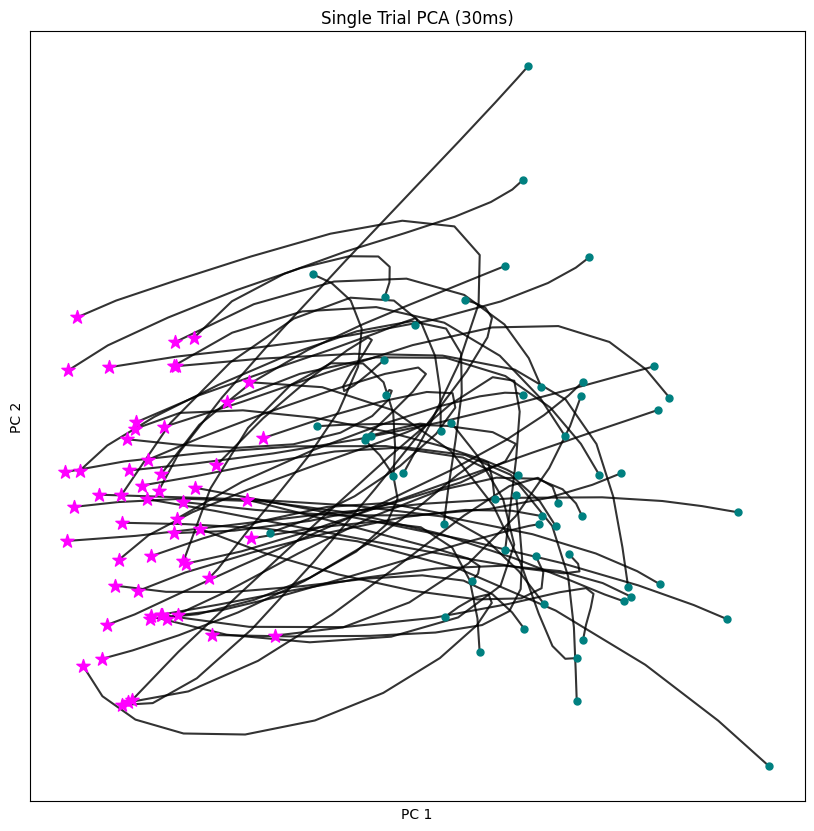

In [158]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)


for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    #p = gaussian_filter1d(p, sigma=2.5, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c="black", zorder=0, alpha=0.8)

    ax.scatter(p[lift_start, 0], p[lift_start, 1], s=25, c="teal", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], s=100, marker='*', c="magenta", zorder=1, alpha=1)


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_all_{bin_size}ms_2d.png')
plt.show()

# Plot all trajectories 3D

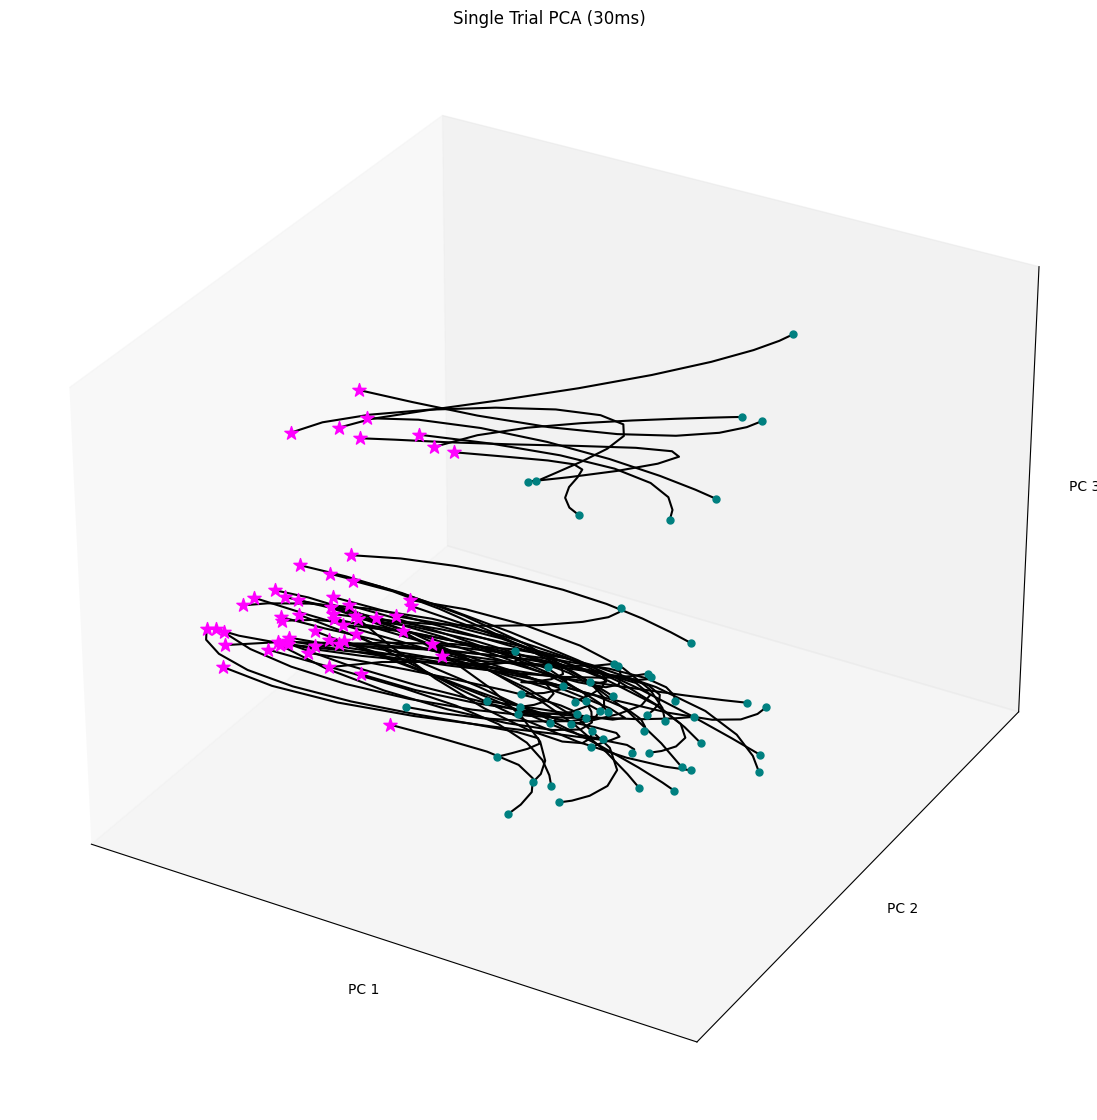

In [159]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    #p = gaussian_filter1d(p, sigma=2.5, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")

    ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=25, c="teal")
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=100, marker="*", c="magenta")


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_all_{bin_size}ms_3d.png")
plt.show()